In [7]:
import sys
import random
import os
sys.path.append(os.path.dirname(os.getcwd()) + "/src/")

import torch
import numpy as np
import torchvision

import torchvision.transforms.transforms as T
from model.public.dip_ae import dip_ae, get_noise
from lightly.models.utils import deactivate_requires_grad

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
default_device = torch.device('cuda:1')
#backbone_load = torch.load("../results/SimCLR-Linear_09-13-2022_14-08-55/checkpoints/checkpoint_epoch299.pt")

In [30]:
backbone = torchvision.models.resnet50(pretrained=True).to(default_device)
backbone.eval()
backbone.fc = torch.nn.Identity()
backbone.avgpool = torch.nn.Identity()
backbone.layer4 = torch.nn.Identity()
deactivate_requires_grad(backbone)

/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
cifar10 = torchvision.datasets.CIFAR10(
    "../datasets",
    train=True,
    transform=T.Compose(
        [
            T.Resize(256),
            T.RandomCrop(224, 4),
            T.ToTensor(),
            #T.Normalize(
                
            #    mean=[0.50707516, 0.48654887, 0.44091784],
            #    std=[0.26733429, 0.25643846, 0.27615047],
            #),
        ]
    ),
)


# Dataset that returns images with nearest neighbor
class NaturalTransformationDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        super(NaturalTransformationDataset, self)
        self.dataset = dataset
        self.nn_graph = torch.arange(len(self.dataset))[:, None]

    def set_nn_graph(self, nn_graph):
        self.nn_graph = nn_graph

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x0, label = self.dataset.__getitem__(idx)
        neighbor = random.randrange(len(self.nn_graph[idx]))
        x1 = self.dataset.__getitem__(int(self.nn_graph[idx, neighbor]))
        return (x0, x1[0], label)


train_dataset = NaturalTransformationDataset(cifar10)
train_dataset.nn_graph = np.load("../results/cifar10_resnet18_nn.npy")
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=10, shuffle=True, num_workers=20
)

In [32]:
x0, x1, y = next(iter(train_dataloader))
z0, z1 = backbone(x0.to(default_device)).detach().cpu(), backbone(x1.to(default_device)).detach().cpu()
print(z0.shape)


torch.Size([10, 200704])


In [26]:
x_recon = []
avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

for i in range(3):
    print("reconstructing image ", i)
    z_use = torch.tensor(z0[0]).to(default_device)
    z_use_avg = avg_pool(z_use.reshape(-1, 7, 7))[..., 0, 0]

    net = dip_ae(32, 3, num_channels_down=[16, 32, 64, 128, 128, 128],
                num_channels_up=[16, 32, 64, 128, 128, 128],
                num_channels_skip=[4, 4, 4, 4, 4, 4],
                filter_size_down=[7, 7, 5, 5, 3, 3], filter_size_up=[7, 7, 5, 5, 3, 3],
                upsample_mode='nearest', downsample_mode='avg',
                need_sigmoid=False, pad='zero', act_fun='LeakyReLU').type(z_use.type()).to(default_device)
    net_input = get_noise(32, 256).type(z_use.type()).detach().to(default_device)
    opt = torch.optim.Adam(list(net.parameters()) + list(net_input), lr=1e-3)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.999)

    for j in range(3000):
        x_hat = net(net_input)[:, :, :224, :224]
        z_hat = backbone(x_hat)
        z_avg = avg_pool(z_use.reshape(-1, 7, 7))[..., 0, 0]

        loss = torch.nn.functional.mse_loss(z_hat[0], z_use)
        loss = loss + (i*10) * torch.nn.functional.mse_loss(z_hat[0], z_use)

        opt.zero_grad()
        loss.backward()
        opt.step()
        #scheduler.step()

        if j % 500 == 0:
            print(loss.item())

    #postpa = torchvision.transforms.Compose([torchvision.transforms.Normalize(
    #                                 mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    #                                 std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
    #                             ])
    #postpb = torchvision.transforms.Compose([torchvision.transforms.ToPILImage()])

    x_hat[x_hat > 1] = 1
    x_hat[x_hat < 0] = 0
    x_recon.append(x_hat[0])

reconstructing image  0
torch.Size([2048])


/tmp/ipykernel_3046065/1088507209.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_use = torch.tensor(z0[0]).to(default_device)


0.4992467164993286
0.020924918353557587
0.011228140443563461
0.009979511611163616
0.006172477267682552
0.005072763189673424
reconstructing image  1
torch.Size([2048])
6.308443069458008
0.71623694896698
0.2134503424167633
0.1930846869945526
0.14670789241790771
0.10629303753376007
reconstructing image  2
torch.Size([2048])
9.77380084991455
0.8913425207138062
0.29878494143486023
0.24338701367378235
0.28326842188835144
0.1494150608778


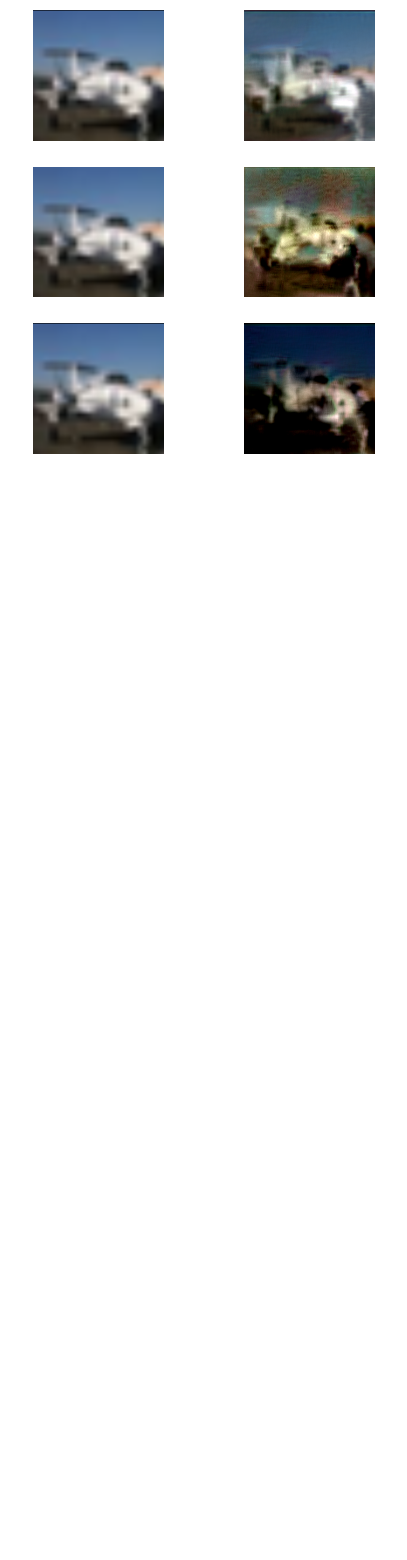

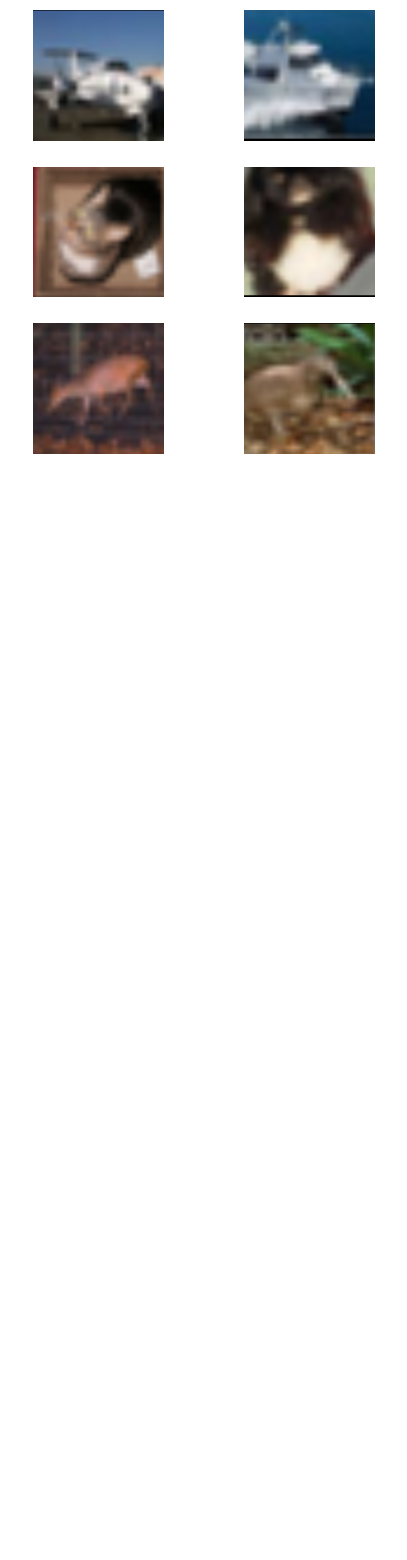

In [29]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(5, 20))
for i in range(3):
    ax[i, 0].imshow(x0[0].detach().cpu().permute(1, 2, 0).numpy())
    ax[i, 1].imshow(x_recon[i].detach().cpu().permute(1, 2, 0).numpy())
[axi.set_axis_off() for axi in ax.ravel()]
print()

fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(5, 20))
for i in range(3):
    ax[i, 0].imshow(x0[i].detach().cpu().permute(1, 2, 0).numpy())
    ax[i, 1].imshow(x1[i].detach().cpu().permute(1, 2, 0).numpy())
[axi.set_axis_off() for axi in ax.ravel()]
print()